#### Nous avons construit notre modèle de classification avec Tensorflow Keras en utilisant un des modèles pré-entraînés de keras 'MobileNetV2'.

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
import itertools
import matplotlib.pyplot as plt 
from sklearn.metrics import classification_report

#### Nous avons utilisé la fonction ImageDataGenerator de Keras pour charger les images à partir de leurs répertoires. 
#### Nous avons fait une augmentation des données sur les données d'entraînement seulement, en changeant par exemple la rotation de l'image, en la décalant suivant sa longueur et sa largeur et en modifiant sa luminosité.

In [2]:
batch_size = 16
# Data directory
train_directory = 'DB/train'
test_directory = 'DB/test'

# Loading train set + Applying data augmentation on train set
train_datagen = ImageDataGenerator(rescale=1./255,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        brightness_range=[0.8,1.0],
        fill_mode="nearest")

# Loading test set
test_datagen = ImageDataGenerator(rescale=1./255)

#### La taille des images qui constituent notre base de données est de 227x227, étant donné que le modèle que nous avons choisi est pré-entraîné sur des images de taille 224x224, nous avons légèrement baissé leurs dimensions afin que l'on puisse les fournir au modèle.

In [3]:
# Generating train batches
train_batches = train_datagen.flow_from_directory(
        train_directory,
        target_size=(224,224),
        batch_size=batch_size,
        color_mode="rgb",
        class_mode='categorical',
        shuffle=True)

# Generating test batches
test_batches = test_datagen.flow_from_directory(
        test_directory,
        target_size=(224,224),
        batch_size=batch_size,
        color_mode="rgb",
        class_mode='categorical',
        shuffle=True)

Found 4736 images belonging to 5 classes.
Found 3568 images belonging to 5 classes.


## Construction de l'architecture du model

#### Nous avons choisi comme modèle le 'MobileNetV2' pré-entraîné sur ImageNet (les images sont de taille 224x224 et sous format RGB). Nous avons choisi ce modèle car il est celui qui contient le moins de paramètres à entraîner et car il a en même temps fourni de très bons résultats sur la base de données d'ImageNet.

#### Nous créons ici un modèle qui reprendra toutes les couches du modèle importé 'mobilenet', on lui ajoutera ensuite la dernière couche de classification avec 5 classes.

In [6]:
# Creating a mobilenet backbone

# We are using pretrained model MobileNetV2 with pretrained ImageNet's weights
backbone = MobileNetV2(weights = 'imagenet', include_top = True, input_shape=(224,224,3))

# We removed the last classification layer to addapt it to our classification problem (5 classes)
backbone.layers.pop()

# We created a sequatial model with a mobilenetv2 backbone and a dense layer with 5 output neurons
model = Sequential()
model.add(backbone)
model.add(Dense(5, activation='softmax', name='predictions'))

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1000)              3538984   
_________________________________________________________________
dense (Dense)                (None, 5)                 5005      
Total params: 3,543,989
Trainable params: 3,509,877
Non-trainable params: 34,112
_________________________________________________________________


In [7]:
# Checkpoint call back
# Save a checkpoint after every epoch is we reached a better validation accuracy

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# Model training
num_train = 4736
num_val = 3568
num_epoch = 10

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-5, decay=1e-6), metrics=['acc'])
model.fit(
        train_batches,
        steps_per_epoch=num_train // batch_size,
        epochs=num_epoch,
        validation_data=test_batches,
        validation_steps=num_val // batch_size,
        callbacks=[model_checkpoint_callback])

# Save the last model
model.save('weights/mobilenet_modele.h5')

#### Nous avons suivi l'entraînement du modèle avec Tensorboard. Cela nous a permis de visualiser la progression de l'accuracy ainsi que de la loss de notre modèle en fonction des epochs. Nous avons également visualisé la progression de la matrice de confusion en fonction des epochs.

Accuracy | Loss
- | - 
![alt text](result/epoch_accuracy.jpg "Evolution of accuracy") | ![alt text](result/epoch_loss.jpg "Evolution of accuracy")

![alt](result/conf_mat.gif "Evolution of Confusion Matrix")

# Évaluation du modèle 

#### Nous évaluons notre modèle sur le set de test seulement.

In [8]:
test_batches = test_datagen.flow_from_directory(
        test_directory,
        target_size=(224,224),
        batch_size=1000,
        color_mode="rgb",
        class_mode='categorical',
        shuffle=True)

Found 3568 images belonging to 5 classes.


In [10]:
model = load_model('weights/mobilenet_model.h5')

In [11]:
# Getting true labels from test_batches 
test_imgs, test_labels = next(test_batches) 
for i in range (test_labels.shape[0]):
    test_labels[i] = np.argmax(test_labels[i])
test_labels = test_labels[:,0]

In [12]:
# Predictions on test batches
predictions = model.predict_generator(test_batches, steps=1, verbose=0)
for i in range (predictions.shape[0]):
    predictions[i] = np.argmax(predictions[i])
predictions = predictions[:,0]

Instructions for updating:
Please use Model.predict, which supports generators.


#### Accuracy du modèle sur le set de test 

In [13]:
accuracy = accuracy_score(test_labels, predictions)
print("Accuracy score : " + str(accuracy))

Accuracy score : 0.971


#### La 'balanced accuracy score' permet de nous donner une justesse qui prend en considération le nombre d'images pour chaque classe. 

In [14]:
balanced_accuracy = balanced_accuracy_score(test_labels, predictions)
print("Balanced accuracy score : " + str(balanced_accuracy))

Balanced accuracy score : 0.9738198315127844


### Matrice de confusion

#### Lorsque l'on fait de la classification multiclasse, il est important de ne pas se limiter à l'accuracy pour évaluer le modèle. C'est pour cela que nous dessinons la matrice de confusion suivante qui permet de montrer les résultats de chaque classe.

In [15]:
cm = confusion_matrix(test_labels, predictions)

In [16]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Reds):
    if normalize : 
        cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).round(2)
    
    thresh = 0.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                horizontalalignment="center",verticalalignment="center",
                color = "white" if cm[i,j] > thresh else "black")
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(0,len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

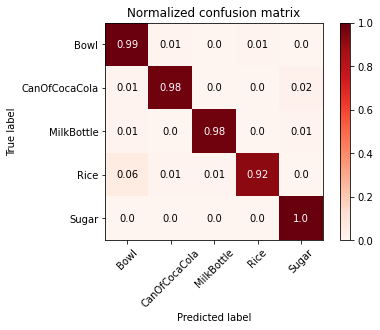

In [17]:
cm_plot_labels = ['Bowl', 'CanOfCocaCola','MilkBottle','Rice','Sugar']
plot_confusion_matrix(cm, cm_plot_labels, title='Normalized confusion matrix')

### Autres métriques 

#### Nous utilisons ci-dessous d'autres métriques (précision, rappel et score F1) pour pousser notre analyse sur les résultats du modèle.

In [18]:
print(classification_report(test_labels, predictions, target_names=['Bowl', 'CanOfCocaCola','MilkBottle','Rice','Sugar']))

               precision    recall  f1-score   support

         Bowl       0.91      0.99      0.95       166
CanOfCocaCola       0.98      0.98      0.98       180
   MilkBottle       0.98      0.98      0.98       177
         Rice       1.00      0.92      0.96       251
        Sugar       0.98      1.00      0.99       226

     accuracy                           0.97      1000
    macro avg       0.97      0.97      0.97      1000
 weighted avg       0.97      0.97      0.97      1000



#### Les bons résultats de précision, rappel et f1-score indiquent un nombre très faible de faux positifs et de faux négatifs. 

In [37]:
test_batches = test_datagen.flow_from_directory(
        test_directory,
        target_size=(224,224),
        batch_size=100,
        color_mode="rgb",
        class_mode='categorical',
        shuffle=False)

Found 3568 images belonging to 5 classes.


In [38]:
model = load_model('weights/mobilenet_modele.h5')

In [39]:
y_pred_raw = model.predict(test_batches)

In [40]:
y_pred = np.argmax(y_pred_raw, axis = 1)
y_true = test_batches.classes

In [41]:
y_true, y_pred

(array([0, 0, 0, ..., 4, 4, 4]), array([0, 0, 0, ..., 4, 4, 4], dtype=int64))

In [42]:
sum([x!=y for x, y in zip(test_labels, predictions)])

3

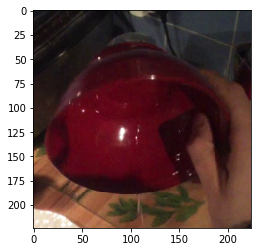

In [58]:
import matplotlib.pyplot as plt
image = test_batches[0]
plt.imshow(image[0][0])